<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model interpretation using RISE for astronomical timeseries data
This notebook shows how to apply the RISE explainability method on a model trained to classify Fast Radio Burst (FRB) timeseries data. The model is a binary classifier that classifies the input as either noise or a real FRB.<br>

[RISE](http://bmvc2018.org/contents/papers/1064.pdf) is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 - Libraries

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import dianna
from dianna import visualization
from dianna.utils import SimpleModelRunner
from dianna.utils.downloader import download

np.random.seed(0)

In [3]:
model_path = download('apertif_frb_dynamic_spectrum_model.onnx', 'model')
classes_path = download('apertif_frb_classes.txt', 'label')
data_path = download('FRB211024.npy', 'data')

#### 1- Load and visualize the data

In [4]:
data = np.load(data_path)

Text(0.5, 1.0, 'FRB 211024')

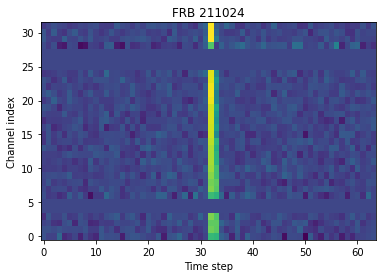

In [5]:
fig, ax = plt.subplots()
ax.imshow(data, aspect='auto', origin='lower')
ax.set_xlabel('Time step')
ax.set_ylabel('Channel index')
ax.set_title('FRB 211024')

In the figure, we see mostly noise, with a bright vertical line in the center. The vertical line is the fast radio burst (FRB) signal. Different channels correspond to different frequencies of light. Some channels are known to contain bad data and are set to zero.

#### The classification task

The goal for a neural network is to determine whether or not the input data contains an FRB-like signal. Hence, it is a binary classification task. The two classes are noise and FRB. The model used here is a convolutional neural network, described further in [this paper](https://doi.org/10.3847/1538-3881/aae649). The model is automatically downloaded by this notebook, and available [here](https://zenodo.org/record/10656614).

Note that the data are timeseries, while a CNN is typically used for images. It works here because neighboring steps in both the time and channel axes are correlated, as would be the case for an image.

#### Select the class to run the explainer for

In [6]:
with open(classes_path) as fp:
    class_names = [line.strip() for line in fp.readlines()]
    
print(f'{class_names=}')
class_to_explain = 'FRB'
labels = [class_names.index(class_to_explain)]
print(f'Will generate explanation for class {class_to_explain}')

class_names=['Noise', 'FRB']
Will generate explanation for class FRB


#### Define function to handle difference between data shape expected by DIANNA and model

Dianna expects input with shape `(time, channel)` while the model and data use `(channel, time)`
In addition, the model needs an extra emtpy axis at the end. 
(model detail: this is because the model is a CNN and the input is processed as if it is an image. The empty axis at the end is the "colour channel" axis)

To handle this, we transpose the input data before feeding it to DIANNA and we define a preprocess function that is called on the data just before it is given to the model. DIANNA creates masked data in batches, so the preprocess function receives data with shape `(batch, time, channel)` which we need to convert to `(batch, channel, time, 1)`. We also convert to `float32`, as this is the only floating point format handled by models in ONNX format.

In [7]:
def preprocess(data):
    return np.transpose(data, (0, 2, 1))[..., None].astype(np.float32)

#### 2 - Run the model

In [8]:
def run_model(input_data):
    """Run the model for a single data item (no batch axis)
    """
    runner = SimpleModelRunner(model_path)
    model_output = runner(preprocess(input_data.T[None, ...]))[0]
    for idx, value in enumerate(model_output):
        print(f'{class_names[idx]}: {value:.2e}', end='    ')
    print()

run_model(data)

Noise: 2.78e-29    FRB: 1.00e+00    


We see that the model is quite sure that the input data contains an FRB. This is indeed correct, however we want to know if the model indeed uses the actual FRB signal (the vertical line in the center of the input data) to come to this conclusion. We will now run the DIANNA timeseries explainer to explore this

#### 3 - Run the explainer

In [10]:
def run_explainer(input_data):
    """Run DIANNA timeseries explainer with fixed parameters
    Returns a heatmap of the same shape as the input data
    """
    # Run the explainer with 5000 masks and a feature resolution of 8 samples, with a 50% chance of keeping a sample in each mask
    n_masks = 5000
    feature_res = input_data.shape[1] // 4  # feature size is roughly 4 timesteps
    p_keep = .1

    # Masked values are replaced by the mean of the input data
    explanation = dianna.explain_timeseries(model_path, input_data.T, method='RISE', labels=labels,
                                            n_masks=n_masks, feature_res=feature_res, p_keep=p_keep,
                                            preprocess_function=preprocess, mask_type='mean')


    # select heatmap of the first (and only) class we ran the explainer for
    heatmap = explanation[0].T
    return heatmap

heatmap = run_explainer(data)

Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.79it/s]


#### 4 -  Plot the explanation and input data next to each other

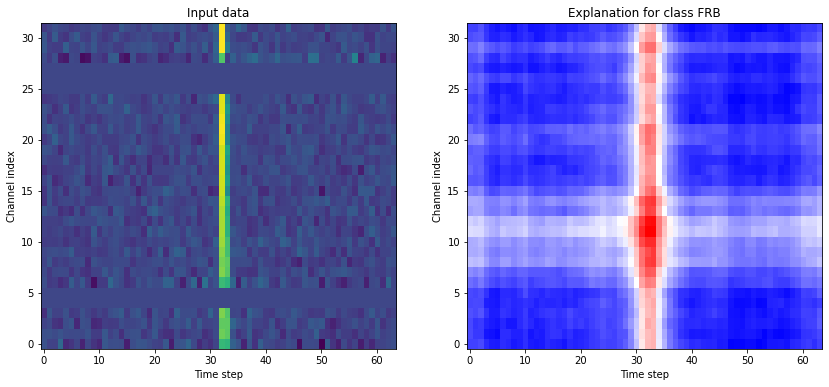

In [12]:
def plot_data_and_heatmap(input_data, output_heatmap):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

    ax = axes[0]
    ax.imshow(input_data, aspect='auto', origin='lower')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Channel index')
    ax.set_title('Input data')

    ax = axes[1]
    ax.imshow(output_heatmap, aspect='auto', origin='lower', cmap='bwr')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Channel index')
    ax.set_title(f'Explanation for class {class_to_explain}')
    
plot_data_and_heatmap(data, heatmap)

#### 5 -  Results

In the explainer output, red means in favour of the given class and blue means against. From the output, we can clearly see that the model is classifying this as an FRB because of the vertical line in the center, which is exactly where the real FRB is located so in this case the model behaves as expected.

#### 6 - Modify the input data
A bright FRB right in the center of the input data is perhaps the easiest for the model to classify correctly, as this is exactly what it was trained for. We now explore two ways the input data may be affected:

1. We can move the FRB signal away from the center of the input data.
2. To simulate deleterious signals from other radio sources on Earth, we can add a bright signal to a few channels that is always on.


#### Move the FRB signal away from the center

In [14]:
# Shift the FRB 10 timesteps to the right
data_shifted = np.roll(data, 10)
run_model(data_shifted)

Noise: 2.81e-08    FRB: 1.00e+00    


In [ ]:
heatmap_shifted = run_explainer(data_shifted)
plot_data_and_heatmap(data_shifted, heatmap_shifted)

We can see that the model handles a modest shift fine, and still uses the real location of the FRB in the data in the classification. However, the model fails once the FRB is too far from the center as we can see in the following example. This may be beacuse in the training data, the FRB was never this far from the center.

Noise: 1.00e+00    FRB: 7.67e-18    


Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.28it/s]


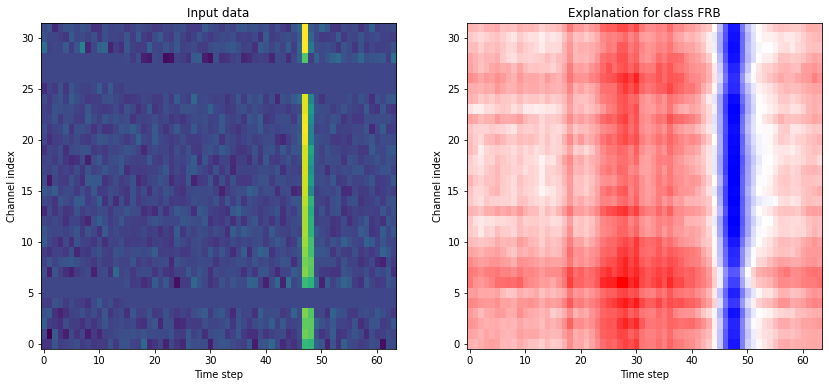

In [15]:
# Shift the FRB 15 timesteps to the right
data_shifted_too_far = np.roll(data, 15)
run_model(data_shifted_too_far)

heatmap_shifted_too_far = run_explainer(data_shifted_too_far)
plot_data_and_heatmap(data_shifted_too_far, heatmap_shifted_too_far)

The model now wrongly classifies the input as noise, and we see the the FRB signal is acutally the main reason why the model is _against_ this being an FRB.

#### Add a deleterious signal

In [16]:
data_with_signal = data.copy()

# we add a deleterious signal that is slightly stronger than the real FRB
rand_mean = 1.5 * np.amax(data)
rand_std = data.std()
data_with_signal[15] = np.random.normal(rand_mean, rand_std, size=data_with_signal.shape[1])
run_model(data_with_signal)

Noise: 4.37e-13    FRB: 1.00e+00    


Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.05it/s]


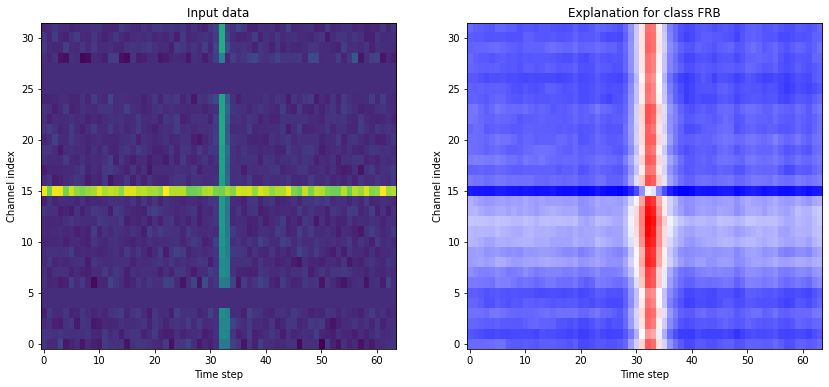

In [17]:
heatmap_with_signal = run_explainer(data_with_signal)
plot_data_and_heatmap(data_with_signal, heatmap_with_signal)

In the output we can see both the real FRB (vertical line) and deleterious signal (horizontal line). In this case, the model still recognizes the FRB. However, we can also see that the deleterious signal does push the model away from the class FRB.

As for the previous example, we can check at which point the model breaks down. Let's rerun with more channels affected by a bad signal.

In [18]:
data_with_too_much_signal = data.copy()

data_with_too_much_signal[12:17] = np.random.normal(rand_mean, rand_std, size=data_with_too_much_signal.shape[1])
run_model(data_with_too_much_signal)

Noise: 1.00e+00    FRB: 9.44e-08    


Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.55it/s]


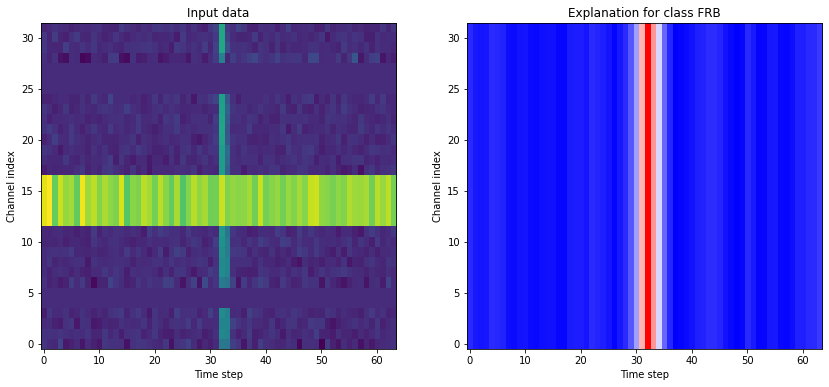

In [19]:
heatmap_with_too_much_signal = run_explainer(data_with_too_much_signal)
plot_data_and_heatmap(data_with_too_much_signal, heatmap_with_too_much_signal)

The model now classifies this as noise. The vertical line in the center is still pushing it towards the FRB class, but not enough . We do see that the bad channels cause the overall input to be more classified as noise.